# Cross Validation Notebook

Mount Google Drive to access data



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Install necessary libraries

In [ ]:
!pip install -e git+https://github.com/ncullen93/torchsample.git#egg=torchsample
!pip install visdom
!pip install nibabel
!pip install h5py
!pip install torchsample
!pip install tensorboardX

Obtaining torchsample from git+https://github.com/ncullen93/torchsample.git#egg=torchsample
  Updating ./src/torchsample clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 1f328d1ea3ef533c8c0c4097ed4a3fa16d784ba4
  Preparing metadata (setup.py) ... done
  Attempting uninstall: torchsample
    Found existing installation: torchsample 0.1.3
    Uninstalling torchsample-0.1.3:
      Successfully uninstalled torchsample-0.1.3
  Running setup.py develop for torchsample


Import libraries

In [ ]:
#import all libraries
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import sys
import pickle
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
# from src.torchsample.torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine
# from torchvision import transforms
import torchvision.transforms as transforms
#from tensorboardX import SummaryWriter
import math
from sklearn import metrics
from sklearn.model_selection import KFold
from torchsummary import summary
from torch.utils.data import DataLoader, random_split, ConcatDataset, SubsetRandomSampler

# Set a random seed for reproducibility
torch.manual_seed(42)

Define GPU / CPU device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Define Dataset class

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, root_dir, task, plane, split='train', transform=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.split=split
        if self.split == 'train':
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        elif self.split == 'test':
            self.folder_path = self.root_dir + 'test/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'test-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)

            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform

        pos = np.sum(self.labels)
        neg = len(self.labels) - pos
        self.weights = [1, neg / pos]


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index]) #load MRI
        label = self.labels[index] #get label of MRI
        label = torch.FloatTensor([label]) #convert type from numpy to torch

        if self.transform: #if you are transforming it
            array = self.transform(array) #transform the image
            array = array.numpy()


        array = np.stack((array,)*3, axis=1) #the model expects dimensions of (3, 256, 256), the MRIs are greyscale of size (256, 256). Therefore, we stack the image three times to fit the dimensions for the model.
        array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

Define model

In [ ]:
#add another fully connected layer to convert output (1,1000) to (1)
class BaselineNetAdapt(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = nn.Sequential(*list(models.resnet18(weights='ResNet18_Weights.DEFAULT').children())[:-2])
        self.conv1 = nn.Conv2d(512,64,4)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,32,4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classifer = nn.Linear(32,1)


    def forward(self, x):
        # input size of x (1, s, 3, 256, 256) where s is the number of slices in one MRI
        x = torch.squeeze(x, dim=0) #output size (s, 3, 256, 256)
        x = self.pretrained_model(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.avgpool(x)
        x = self.flatten(x)

        output = torch.max(x, 0, keepdim=True)[0] #output size (1, 1000)
        output =nn.ReLU()(output)
        output = self.classifer(output) #output size (1)

        return output

In [ ]:
ResNet18Adapt_model = BaselineNetAdapt().to(device)
#summary(ResNet18Adapt_model, (3, 256, 256))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 22.1MB/s]


Define Variables

In [ ]:
folder = '/content/gdrive/MyDrive/assignment/'
model_name = 'ResNet18Adapt_CV'
filename=folder + 'model_weights/' + model_name + '_weights_acl_coronal.pth'
filename

'/content/gdrive/MyDrive/assignment/model_weights/ResNet18Adapt_CV_weights_acl_coronal.pth'

In [ ]:
directory=folder + 'MRNet-v1.0/MRNet-v1.0/'
task = 'meniscus'
plane = 'axial'
lr = 1e-5 #learning rate

optimizer = optim.Adam(ResNet18Adapt_model.parameters(), lr= lr, weight_decay=0.1) #define the optimiser as Adam ()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=4, factor=.3, threshold=1e-4, verbose=True) #define a scheduler that decreases the learning rate if there has been no reduction in validation loss is four epochs


Initialise data transformations and data loadesr.

In [ ]:
# define a compose function that is a series of transformations on the images.
augmentor = transforms.Compose([
            # transforms.Lambda(lambda x: torch.Tensor(x)), #converts from numpy to tensor
            transforms.ToTensor(),  # Convert images to tensors
            transforms.Resize((299, 299), antialias=True),  # Resize images to 299by299
            transforms.RandomRotation(25), #rotate the image by 25 degrees
            transforms.RandomAffine([0.11, 0.11]), #blur the edges
            transforms.RandomHorizontalFlip() #flip the image
        ])

# initialise the train and validation datasets (class we defined earlier) and then initialise a Pytorch's dataloader
train_dataset = Dataset(directory, task, plane, split='train', transform=None) # Set as none for optimiser training
valid_dataset = Dataset(directory, task, plane, split='valid', transform = None)
#test_dataset = Dataset(directory, task, plane, split='test', transform = None)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=-True, num_workers=2, drop_last=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=-True, num_workers=2, drop_last=False)

Concatenate training and validation dataset. Cross Validation will run on both training and validation dataset.

In [ ]:
dataset = ConcatDataset([train_dataset, valid_dataset])
print(len(dataset))

1130


**Due to limited memory and processing power, cross validation run on a subset of the available augmented data (20%)**

Having **data augmentation active**, I was not able even to debug the code. Thus, I was reduced to **subscribe to Colab Pro+.** Code debugging performed with 1% of dataset. Cross Validation run with 20% of augmented data.

But after some runs for code debugging and runs with 20% of augmented data, I run out of compute units.

This version of notebook demonstrates cross validation with **5% of non augmented data**.

In [ ]:
from torch.utils.data import Subset

reduced_dataset = Subset(dataset, indices=range(len(dataset) // 20)) # set 5 to get 20% or set 100 to get 1%
print(len(reduced_dataset))


56


Define training function. It runs for each epoch

In [ ]:
def train_epoch(model, train_loader, optimizer):
    train_loss = 0.0
    train_acc = 0
    model.train()
    #print('len {}'.format(len(tr_loader)))
    #print("TRAINING")
    i = 0
    for images, labels, weights in train_loader:

        #print('i {}'.format(i))
        if torch.cuda.is_available():
            images,labels,weights = images.to(device),labels.to(device),weights.to(device)

        optimizer.zero_grad()
        output = model(images)
        #loss = loss_fn(output,labels)

        loss = torch.nn.BCEWithLogitsLoss(weight=weights)(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_acc += (predictions == labels).sum().item()
        #print("train predictions:", predictions, " label: ", labels )
        if torch.cuda.is_available():
          del images
          del labels
          del weights
        i = i+1
    return train_loss,train_acc


Define validation function. It runs for each epoch.

In [ ]:
def valid_epoch(model,valid_loader):
    valid_loss = 0.0
    valid_acc = 0
    #print("Validation")
    model.eval()
    i = 0
    #print('len {}'.format(len(val_loader)))
    for images, labels, weights in valid_loader:
        #print('i {}'.format(i))
        if torch.cuda.is_available():
            images,labels,weights = images.to(device),labels.to(device),weights.to(device)

        output = model(images)
        loss = torch.nn.BCEWithLogitsLoss(weight=weights)(output, labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        valid_acc += (predictions == labels).sum().item()
        #print("Val predictions:", predictions , " label: ", labels )
        if torch.cuda.is_available():
          del images
          del labels
          del weights
        i = i+1

    return valid_loss, valid_acc

Define cross validation function.

In [ ]:
def cross_validation(model, optimizer, dataset, num_epochs, k):
  performace_of_folds=[]

  kf = KFold(n_splits=k, shuffle=True,random_state=42)
  print(kf)
  kf.get_n_splits(dataset)

  for fold, (train_idx,val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
    history_of_each_fold = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
    print('---- Fold {}'.format(fold + 1))
    print(f"  Length of Train: index={len(train_idx)}")
    print(f"  Length of Test:  index={len(val_idx)}")
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=1, sampler=train_sampler)

    valid_loader = DataLoader(dataset, batch_size=1, sampler=val_sampler)
    #print("len of train_loader: ", len(train_loader))
    #print("len of valid_loader: ", len(valid_loader))

    for epoch in range(num_epochs):
      #print('epoch {}'.format(epoch + 1))

      train_loss, train_acc_epoch = train_epoch(model,train_loader,optimizer)
      val_loss, val_acc_epoch = valid_epoch(model,valid_loader)

      train_loss = train_loss / len(train_loader.sampler)
      train_acc = train_acc_epoch / len(train_loader.sampler) * 100
      val_loss = val_loss / len(valid_loader.sampler)
      val_acc = val_acc_epoch / len(valid_loader.sampler) * 100

      print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                          num_epochs,
                                                                                                          train_loss,
                                                                                                          val_loss,
                                                                                                          train_acc,
                                                                                                          val_acc))
      history_of_each_fold['train_loss'].append(train_loss)
      history_of_each_fold['val_loss'].append(val_loss)
      history_of_each_fold['train_acc'].append(train_acc)
      history_of_each_fold['val_acc'].append(val_acc)
    performace_of_folds.append(history_of_each_fold)
  # compute statistics
  training_losses = []
  validation_losses = []
  training_accs = []
  validation_accs = []
  folds = []
  for fold in range(0,k):

    training_losses.append(np.mean(performace_of_folds[fold]['train_loss']))
    validation_losses.append(np.mean(performace_of_folds[fold]['val_loss']))

    training_accs.append(np.mean(performace_of_folds[fold]['train_acc']))
    validation_accs.append(np.mean(performace_of_folds[fold]['val_acc']))
    folds.append(fold+1)
  training_losses.append(np.mean(training_losses))
  validation_losses.append(np.mean(validation_losses))
  training_accs.append(np.mean(training_accs))
  validation_accs.append(np.mean(validation_accs))
  folds.append("average")
  cv_statistics = {
    "Folds": folds,
    "Training Loss": training_losses,
    "Validation Loss": validation_losses,
    "Training Accuracy": training_accs,
    "Validation Accuracy": validation_accs,
  }

  #load data into a DataFrame object:
  cv_statistics_df = pd.DataFrame(cv_statistics)

  # save trained model
  torch.save(model.state_dict(), filename)
  return model, performace_of_folds, cv_statistics_df



Run cross validation

In [ ]:
num_epochs=10
k_folds = 5 # number of folds
trained_model, performace_of_folds, cv_statistics_df = cross_validation(ResNet18Adapt_model, optimizer, reduced_dataset, num_epochs, k_folds)


KFold(n_splits=5, random_state=42, shuffle=True)
---- Fold 1
  Length of Train: index=44
  Length of Test:  index=12
Epoch:1/10 AVG Training Loss:0.973 AVG Test Loss:1.004 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:2/10 AVG Training Loss:0.637 AVG Test Loss:1.006 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:3/10 AVG Training Loss:0.482 AVG Test Loss:1.002 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:4/10 AVG Training Loss:0.373 AVG Test Loss:1.019 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:5/10 AVG Training Loss:0.299 AVG Test Loss:1.026 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:6/10 AVG Training Loss:0.241 AVG Test Loss:1.051 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:7/10 AVG Training Loss:0.199 AVG Test Loss:1.048 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:8/10 AVG Training Loss:0.168 AVG Test Loss:1.076 AVG Training Acc 56.82 % AVG Test Acc 50.00 %
Epoch:9/10 AVG Training Loss:0.143 AVG Test Loss:1.098 AVG Training Acc 56.

In [ ]:
cv_statistics_df

,Folds,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy
0,1,0.363701,1.041517,56.818182,50.000000
1,2,0.106793,0.453556,51.111111,72.727273
2,3,0.037354,0.243858,51.111111,72.727273
3,4,0.015997,0.223104,57.777778,45.454545
4,5,0.007972,0.243914,60.000000,36.363636
5,average,0.106363,0.441190,55.363636,55.454545


In [ ]:
print(cv_statistics_df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))

\begin{tabular}{lrrrr}
\toprule
  Folds &  Training Loss &  Validation Loss &  Training Accuracy &  Validation Accuracy \\
\midrule
      1 &           0.36 &             1.04 &              56.82 &                50.00 \\
      2 &           0.11 &             0.45 &              51.11 &                72.73 \\
      3 &           0.04 &             0.24 &              51.11 &                72.73 \\
      4 &           0.02 &             0.22 &              57.78 &                45.45 \\
      5 &           0.01 &             0.24 &              60.00 &                36.36 \\
average &           0.11 &             0.44 &              55.36 &                55.45 \\
\bottomrule
\end{tabular}



<ipython-input-17-006eddc3baef>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cv_statistics_df.to_latex(index=False,


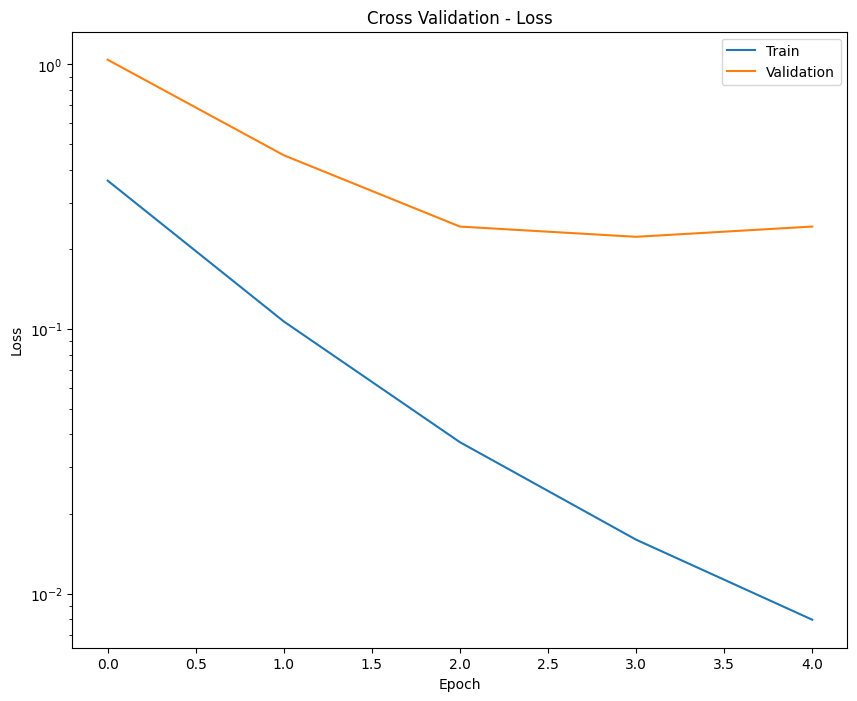

In [ ]:
# Plot losses

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.semilogy(cv_statistics_df.loc[0:k_folds-1, 'Training Loss'], label='Train')
plt.semilogy(cv_statistics_df.loc[0:k_folds-1, 'Validation Loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('Cross Validation - Loss')
plt.show()

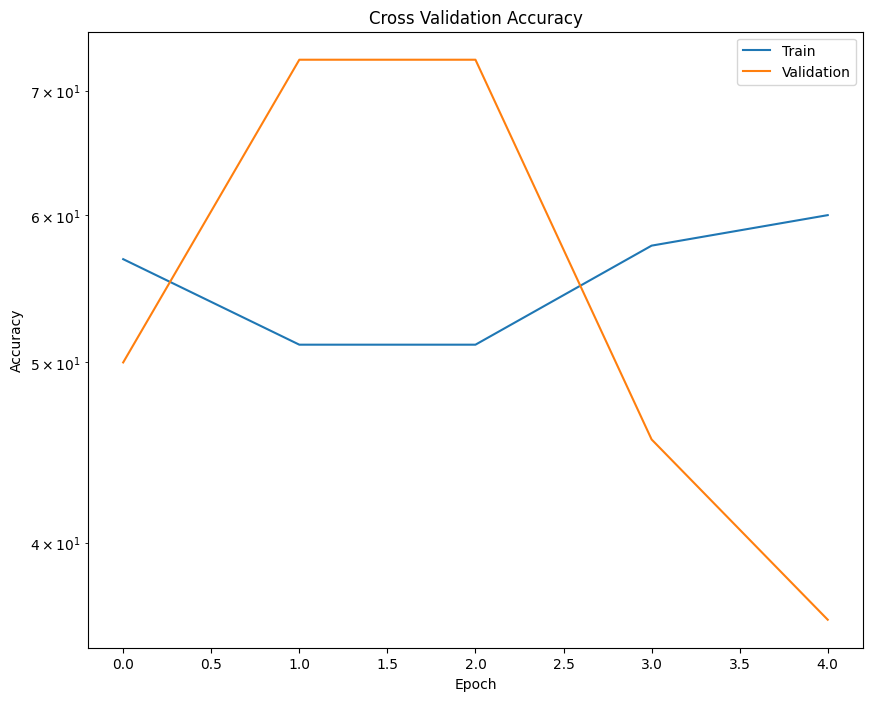

In [ ]:
# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(cv_statistics_df.loc[0:k_folds-1, 'Training Accuracy'], label='Train')
plt.semilogy(cv_statistics_df.loc[0:k_folds-1, 'Validation Accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('Cross Validation Accuracy')
plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 203891 KiB |  19979 MiB | 412251 GiB | 412250 GiB |
|       from large pool | 189952 KiB |  19965 MiB | 412106 GiB | 412106 GiB |
|       from small pool |  13939 KiB |     23 MiB |    144 GiB |    144 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 203891 KiB |  19979 MiB | 412251 GiB | 412250 GiB |
|       from large pool | 189952 KiB |  19965 MiB | 412106 GiB |

In [ ]:
torch.cuda.empty_cache()